Todo:
    
    1. Review current notebook
    2. Review the anlaysis of Credit card for understanding data and filling missing data
    2. Add Logistic Regression using stats model
    3. Add Feature Selection in Credit card analysis
    4. Review and add methods of reference Feature Selection
    5. Try with other datasets

# 1. Import library

In [62]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score

# Evaluation metrics for Classification
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# Evaluation metrics for Regression 
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, roc_auc_score, auc,
                             precision_score, recall_score, roc_curve, precision_recall_curve,
                             precision_recall_fscore_support, f1_score,
                             precision_recall_fscore_support)

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_classif, f_regression

# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

print("Setup complete...")

Setup complete...


# 2. Import data

In [7]:
# load dataset
df = pd.read_csv('../Data/Credit_Card_Applications.csv')
df.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


# 3. Separate train set and test set

In all feature selection procedures, it is goog practice to select the features by examining only the trainingset. And this is to avoid overfitting

In [8]:
X = df.drop(['CustomerID','Class'], axis=1)
y = df['Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

X_train.shape, X_test.shape

((483, 14), (207, 14))

In [9]:
# I keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
X_test_original = X_test.copy()

original_features = X_train_original.columns
original_features

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14'],
      dtype='object')

# 4. Basic Filter

### 4.1. Remove constant features

Constant features are those that show the same value, just one value, for all the observations of the dataset. This is, the same value for all the rows of the dataset. These features provide no information that allows a machine learning model to discriminate or predict a target

In [10]:
# remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]
features_to_keep = [var for var in X_train.columns if var not in constant_features]

print(constant_features)
print()
print(features_to_keep)

[]

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14']


### 4.2. Remove quasi-constant features

Quasi-constant features are those that show the same value for the great majority of the observations of the dataset. In general, these features provide little if any information that allows a machine learning model to discriminate or predict a target. But there can be exceptions. So you should be careful when removing these type of features

Variance threshold from sklearn is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples.

In [11]:
# remove quasi-constant features
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(X_train)  # fit finds the features with low variance

sum(sel.get_support()) # how many not quasi-constant?

14

In [14]:
quasiconst_features = [x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]
features_to_keep = X_train.columns[sel.get_support()]

print(quasiconst_features)
print()
print(features_to_keep)

[]

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14'],
      dtype='object')


In [15]:
# sklearn transformations lead to numpy arrays
# here I transform the arrays back to dataframes
# please be mindful of getting the columns assigned
# correctly

X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

### 4.3. Remove duplicated features

Often datasets contain one or more features that show the same values across all the observations. This means that both features are in essence identical. In addition, it is not unusual to introduce duplicated features after performing **one hot encoding** of categorical variables, particularly when using several highly cardinal variables.

Identifying and removing duplicated, and therefore redundant features, is an easy first step towards feature selection and more easily interpretable machine learning models.

**Note**
Finding duplicated features is a computationally costly operation in Python, therefore depending on the size of your dataset, you might not always be able to perform it.

In [16]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10


0

In [17]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((483, 14), (207, 14))

In [19]:
# I keep a copy of the dataset except constant and duplicated variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

basic_filter = X_train.columns
print(basic_filter)

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14'],
      dtype='object')


### 4.4. Remove correlated features

Correlation Feature Selection evaluates subsets of features on the basis of the following hypothesis: "Good feature subsets contain features highly correlated with the target, yet uncorrelated to each other".

#### Examining and removing related features

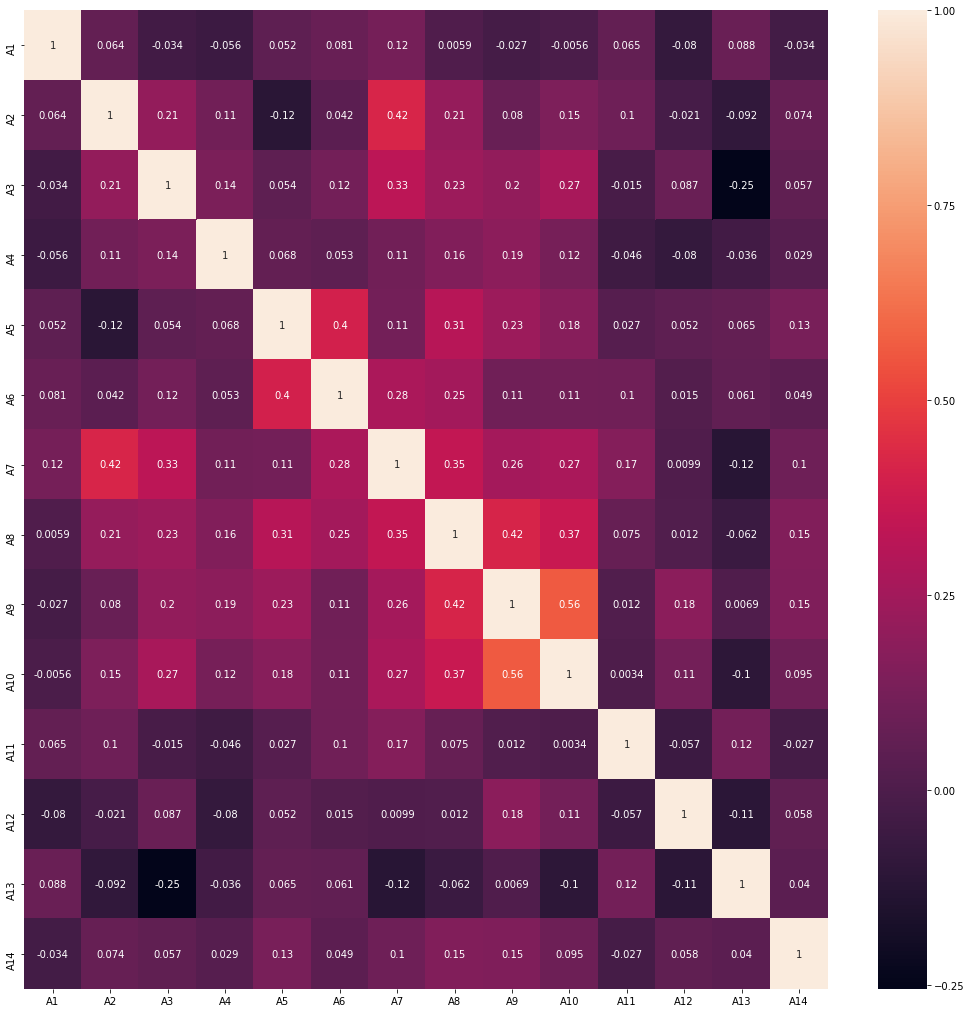

In [24]:
# Correlation matrix
corrmat = X_train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(18,18)
sns.heatmap(corrmat, annot = True)
plt.show()

In [25]:
corrmat

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
A1,1.000000,0.064092,-0.034419,-0.056035,0.052122,0.081357,0.119938,0.005873,-0.026625,-0.005575,0.064605,-0.079616,0.087648,-0.033836
A2,0.064092,1.000000,0.209161,0.112696,-0.116825,0.042025,0.420148,0.212950,0.080401,0.146167,0.099595,-0.020812,-0.092423,0.074419
A3,-0.034419,0.209161,1.000000,0.139341,0.053818,0.116925,0.325281,0.230706,0.202335,0.266226,-0.014541,0.086912,-0.254696,0.057420
A4,-0.056035,0.112696,0.139341,1.000000,0.068002,0.052846,0.111676,0.155727,0.187297,0.123932,-0.046445,-0.079857,-0.036469,0.028745
A5,0.052122,-0.116825,0.053818,0.068002,1.000000,0.400857,0.112981,0.312942,0.231790,0.175781,0.026789,0.052407,0.064992,0.131450
A6,0.081357,0.042025,0.116925,0.052846,0.400857,1.000000,0.278371,0.253953,0.106634,0.111790,0.104380,0.015318,0.060539,0.048678
A7,0.119938,0.420148,0.325281,0.111676,0.112981,0.278371,1.000000,0.345417,0.258419,0.273193,0.165560,0.009923,-0.122246,0.099566
A8,0.005873,0.212950,0.230706,0.155727,0.312942,0.253953,0.345417,1.000000,0.416006,0.365321,0.074629,0.011503,-0.061599,0.154355
A9,-0.026625,0.080401,0.202335,0.187297,0.231790,0.106634,0.258419,0.416006,1.000000,0.564463,0.011989,0.184185,0.006890,0.151216
A10,-0.005575,0.146167,0.266226,0.123932,0.175781,0.111790,0.273193,0.365321,0.564463,1.000000,0.003430,0.113567,-0.103589,0.094987


#### Approach 1: Brute force approach

In [20]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  0


#### Approach 2: Identify groups of highly correlated features

The second approach looks to identify groups of highly correlated features. And then, we can make further investigation within these groups to decide which feature we keep and which one we remove.

In [26]:
# build a dataframe with the correlation between features
# remember that the absolute value of the correlation
# coefficient is important and not the sign

corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat

A1   A1     1.000000
     A2     0.064092
     A3     0.034419
     A4     0.056035
     A5     0.052122
              ...   
A14  A10    0.094987
     A11    0.026858
     A12    0.058236
     A13    0.039520
     A14    1.000000
Length: 196, dtype: float64

In [27]:
corrmat = corrmat.sort_values(ascending=False)
corrmat

A14  A14    1.000000
A13  A13    1.000000
A2   A2     1.000000
A3   A3     1.000000
A4   A4     1.000000
              ...   
A8   A1     0.005873
A1   A10    0.005575
A10  A1     0.005575
A11  A10    0.003430
A10  A11    0.003430
Length: 196, dtype: float64

In [28]:
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,A14,A14,1.0
1,A13,A13,1.0
2,A2,A2,1.0
3,A3,A3,1.0
4,A4,A4,1.0


In [29]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))

found 1 correlated groups
out of 14 total features


#### removed correlated  features

In [21]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((483, 14), (207, 14))

In [22]:
# keep a copy of the dataset at  this stage
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

basic_filter = X_train.columns
print(basic_filter)

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14'],
      dtype='object')


------------------------------------------------------------------------

# 5. Filter method (Univariate Feature Selection)

### 5.1. t-test

In [37]:
import scipy

df0 = df[df['Class'] == 0]
df1 = df[df['Class'] == 1]

column_list = X_train.columns
ttest_df = pd.DataFrame(columns = ['Feature','t-stats','p-value'])
ttest_df['Feature'] = column_list

for var in column_list:
    result = scipy.stats.ttest_ind(df0[var], df1[var])
    ttest_df.loc[ttest_df['Feature'] == var,'t-stats'] = result[0]
    ttest_df.loc[ttest_df['Feature'] == var,'p-value'] = result[1]

ttest_df['abs_t-stats'] = np.abs(ttest_df['t-stats'])
ttest_df.sort_values('abs_t-stats',ascending = False)

,Feature,t-stats,p-value,abs_t-stats
7,A8,-27.2454,1.93682e-111,27.2454
8,A9,-13.5252,3.94126e-37,13.5252
9,A10,-11.667,7.95772e-29,11.667
4,A5,-10.5681,2.71089e-24,10.5681
6,A7,-8.93582,3.67105e-18,8.93582
5,A6,-6.67344,5.14413e-11,6.67344
2,A3,-5.52998,4.55168e-08,5.52998
3,A4,-5.19562,2.69162e-07,5.19562
13,A14,-4.68022,3.45203e-06,4.68022
1,A2,-4.29589,1.99058e-05,4.29589


In [39]:
ttest_features = ttest_df[ttest_df['p-value'] <= 0.05].Feature.values
print(ttest_features)

['A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'A10' 'A12' 'A13' 'A14']


### 5.2. Whitney Test

### 5.3. Information Gain - Mutual Information

Mutual information measures how much information a feature contributes to making the correct prediction on Y

Mutual information measures the information that X and Y share: It measures how much knowing one of these variables reduces uncertainty about the other. For example, if X and Y are independent, then knowing X does not give any inforatmion about Y and vice versa, so their mutual information is zero. At the other extreme, if X is a deterministic function of Y and Y is a deterministic function of X then all information conveyed by X is shared with Y: knowing X determines the value of Y and vice versa. As a result, in this case the mutual information is the same as the uncertainty contained in Y (or X) alone, namely the entropy of Y (or X). Moreover, this mutual information is the same as the entropy of X and as the entropy of Y. (A very special case of this is when X and Y are the same random variable)

In [41]:
# Calculate the mutual information between the variables and the target.
# This returns the mutual information value of each feature 
# The smaller the value the less information the feature has about the target

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

mi = mutual_info_classif(X_train, y_train)
mi

array([0.        , 0.00588705, 0.        , 0.02759334, 0.09518631,
       0.        , 0.11924399, 0.31801741, 0.11861299, 0.13208366,
       0.        , 0.        , 0.05394046, 0.11085726])

In [44]:
# Add variable names and order the features according to the MI for clearer visualization

mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending = False)

A8     0.318017
A10    0.132084
A7     0.119244
A9     0.118613
A14    0.110857
A5     0.095186
A13    0.053940
A4     0.027593
A2     0.005887
A12    0.000000
A11    0.000000
A6     0.000000
A3     0.000000
A1     0.000000
dtype: float64

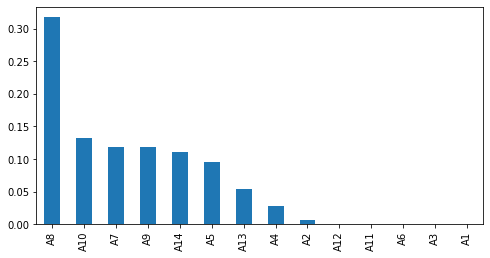

In [46]:
# Plot the ordered MI values per feature

mi.sort_values(ascending = False).plot.bar(figsize=(8,4))

Comparatively, we can see that there are a few features (left of the plot) that seem to contribute the most to predicting the target. There are also a few features with almost zero MI values on the right of the plot

where to put the cut-off to select features is arbitrary. One could choose a certain value of MI after studying the plot above. An alternative and most frequent way of selecting features is to select the top 10, or top 20 features, or the features in the the top 10th percentile of the MI value distribution

To do this, you can use mutual info in combination with SelectKBest or SelectPercentile from sklearn. SelectKBest allows you to determine how many features, and SelectPercentile the features within a certain percentile

In [51]:
# here I will select the top 10 features
# which are shown below

from sklearn.feature_selection import SelectKBest, SelectPercentile

sel_ = SelectKBest(mutual_info_classif, k=8).fit(X_train, y_train)
mi_features = X_train.columns[sel_.get_support()]
print(mi_features)

Index(['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A13', 'A14'], dtype='object')


### 5.4. Pearson Correlation

#### Calculate correlation

In [52]:
cor_list = []
feature_name = X_train.columns.tolist()

for i in X_train.columns.tolist():
    cor = np.corrcoef(X[i], y)[0, 1]
    cor_list.append(cor)
cor_list = [0 if np.isnan(i) else i for i in cor_list]
cor_list = np.round(np.abs(cor_list),3)
cor_list

array([0.014, 0.162, 0.206, 0.194, 0.374, 0.247, 0.322, 0.72 , 0.458,
       0.406, 0.032, 0.115, 0.1  , 0.176])

#### Set feature importance

In [53]:
cor_support = cor_list > cor_list.mean()
cor_support

array([False, False, False, False,  True, False,  True,  True,  True,
        True, False, False, False, False])

In [57]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(feature_name, cor_list), key=lambda x: x[1] * -1)
corr_features = pd.DataFrame(values, columns = headers)
corr_features

,name,score
0,A8,0.720
1,A9,0.458
2,A10,0.406
3,A5,0.374
4,A7,0.322
5,A6,0.247
6,A3,0.206
7,A4,0.194
8,A14,0.176
9,A2,0.162


### 5.5 Single AUC for each variable

In [65]:
auc_list = []
feature_name = X_train.columns.tolist()

for i in feature_name:
        fpr, tpr, thresholds = roc_curve(np.array(y_train), np.array(X_train[i]))
        if auc(fpr, tpr)+0>0.5:
             z = auc(fpr, tpr)+0
        else:       
            z= 1 - auc(fpr, tpr)+0
        auc_list.append(z)

auc_support = np.array(auc_list) > np.array(auc_list).mean()
auc_support

array([False, False, False, False,  True, False,  True,  True,  True,
        True, False, False, False,  True])

In [67]:
headers = ["name","score"]
values = sorted(zip(feature_name, auc_list), key=lambda x: x[1] * -1)
auc_features = pd.DataFrame(values, columns = headers)
auc_features

,name,score
0,A8,0.865750
1,A10,0.772119
2,A7,0.734233
3,A9,0.734111
4,A5,0.713537
5,A14,0.659163
6,A3,0.629243
7,A6,0.626406
8,A2,0.592529
9,A13,0.571937


### 5.6. Univariate ROC-AUC or MSE

This procedure works as follows:
    + First, it builds one selection tree per feature, to predict the target
    + Second, it makes predictions using the decision tree and the mentioned feature
    + Third, it ranks the features according to the machine learning metric (roc-auc or mse)
    + It selects the highest ranked features

In [69]:
from sklearn.tree import DecisionTreeClassifier

# loop to build a tree, make predictions and get the roc-auc for each feature of the train set
roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
rocauc_support = roc_values > np.array(roc_values).mean()
rocauc_support

array([False, False, False, False,  True, False, False,  True,  True,
        True, False, False,  True,  True])

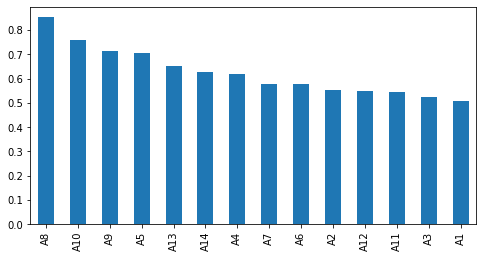

In [70]:
# Add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(8, 4))

In [71]:
headers = ["name","score"]
values = sorted(zip(feature_name, roc_values), key=lambda x: x[1] * -1)
rocauc_features = pd.DataFrame(values, columns = headers)
rocauc_features[0:10]

,name,score
0,A8,0.853261
1,A10,0.759263
2,A9,0.714130
3,A5,0.707183
4,A13,0.651938
5,A14,0.626229
6,A4,0.617391
7,A7,0.577836
8,A6,0.577174
9,A2,0.551276


In [73]:
# a roc auc value of 0.5 indicates random decision
# let's check how many features show a roc-auc value
# higher than random

len(roc_values[roc_values > 0.5])

14

### 5.7. Fisher Score

Compute chi-squared stats between each non-negative feature and class. This score should be used to evaluate categorical variables in a classification task

It compares the observed distribution of the different classes of target Y among the different categories of the feature, against the expected distribution of the target classes, regardless of the feature categories.

#### Chi-2

In [75]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

chi_selector = SelectKBest(chi2, k=10)
chi_selector.fit(X_train, y_train)
# check which one is selected
chi_support = chi_selector.get_support(indices=False)
chi_support

array([False,  True,  True, False,  True,  True,  True,  True,  True,
        True, False, False,  True,  True])

In [76]:
chi_selector.get_support(indices=True)
chi_feature = X_train.loc[:,chi_support].columns.tolist()
chi_feature[0:10]

['A2', 'A3', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A13', 'A14']

In [79]:
# Variable Importance
feature_list = X_train.columns
# Get numerical feature importance
importance_list = list(chi_selector.scores_)
# p value
pvalue_list = list(chi_selector.pvalues_)

#get feature importances from the model
headers = ["name", "score", "pvalue"]
# values = sorted(zip(feature_list, cor_list, pvalue_list), key=lambda x: x[1] * -1)
values = sorted(zip(feature_list, importance_list, pvalue_list))
values = sorted(values, key = lambda x: x[1], reverse = True)
chi_features = pd.DataFrame(values, columns = headers)
chi_features[0:10]

,name,score,pvalue
0,A14,284221.475916,0.000000e+00
1,A10,797.270012,2.116464e-175
2,A13,555.463724,8.154903e-123
3,A7,276.675841,3.981101e-62
4,A3,126.270488,2.683040e-29
5,A5,122.831040,1.518442e-28
6,A8,118.584506,1.291337e-27
7,A9,61.025043,5.635338e-15
8,A2,55.615484,8.812676e-14
9,A6,29.209631,6.495552e-08


### 5.8. Univariate feature selection

Univariate feature selection works by selecting the best features based on univariate statistical tests (ANOVA). The methods based on F-test estimate the degree of linear dependency between two random variables. They assume a linear relationship between the feature and the target. These methods also assume that the variables follow a Gaussian distribution.

These may not always be the case for the variables in your dataset, so if looking to implement these procedure, you will need to corroborate these assumptions.

For the sake of the demonstration, I will assume that the variables show a linear relationship with the target, and that they are normally distributed. But when or if you choose to implement these selection procedure for your features, you will have to check that this is the case, to make sure you are implementing the right method.

#### f_classif

In [80]:
# calculate the univariate statistical measure between
# each of the variables and the target
# similarly to chi2, the output is the array of f-scores
# and an array of pvalues, which are the ones we will compare

univariate = f_classif(X_train, y_train)

In [81]:
# let's add the variable names and order it for clearer visualisation
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=False, inplace=True)

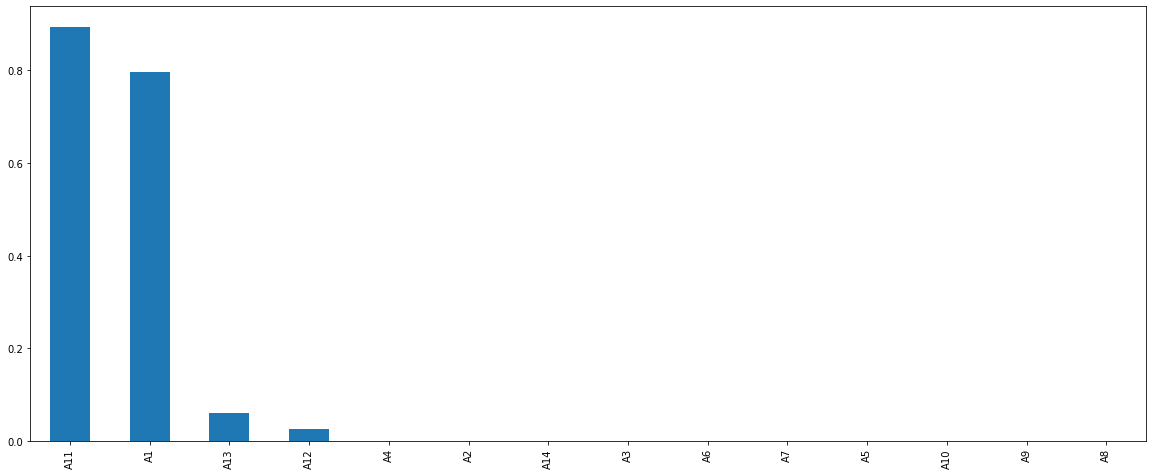

In [82]:
# and now let's plot the p values
univariate.sort_values(ascending=False).plot.bar(figsize=(20, 8))

Remember that the lower the p_value, the most predictive the feature is in principle. There are a few features that do not seem to have predictive power according to this tests, which are those on the left with pvalues above 0.05. Given that typically in statistics one uses a pvalue of 0.05 as a cut-off, I am inclined to believe that those features with pvalue > 0.05 are indeed not important. However, keep in mind that this test assumes a linear relationship, so it might also be the case that the feature is related to the target but not in a linear manner.

Further investigation is needed if we want to know the true nature of the relationship between feature and target.

Similarly to what I mentioned in the previous lecture, in big datasets it is not unusual that the pvalues of the different features are really small. This does not say as much about the relevance of the feature. Mostly it indicates that it is a big the dataset.

Once again, where we put the cut-off to select features is a bit arbitrary. One way is to select the top 10, 20 features. Alternatively, the top 10th percentile. For this, you can use anova in combination with SelectKBest or SelectPercentile from sklearn. See below.

In [84]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


f_selector = SelectKBest(f_classif, k=10)
f_selector.fit_transform(X_train, y_train)
f_support = f_selector.get_support()
f_feature = X_train.loc[:,f_support].columns.tolist()
f_feature[0:10]

['A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A14']

In [86]:
# Variable Importance
feature_list = X_train.columns
# Get numerical feature importance
importance_list = list(f_selector.scores_)
# p value
pvalue_list = list(f_selector.pvalues_)

#get feature importances from the model
headers = ["name", "score", "pvalue"]
values = sorted(zip(feature_list, importance_list, pvalue_list))
values = sorted(values, key = lambda x: x[1], reverse = True)
f_features = pd.DataFrame(values, columns = headers)
f_features[0:10]

,name,score,pvalue
0,A8,546.270914,2.771038e-81
1,A9,136.541699,6.107715e-28
2,A10,92.801320,3.353074e-20
3,A5,78.202112,1.770294e-17
4,A7,63.278479,1.294911e-14
5,A6,35.103591,5.962841e-09
6,A3,25.923890,5.106143e-07
7,A14,18.717831,1.844183e-05
8,A2,12.476739,4.517718e-04
9,A4,11.788217,6.475687e-04


In [85]:
f_support

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False,  True])

--------------------------------------------------------------------------

# 6. Wrapper Methods

### 6.1. Step forward feature selection

Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k < d

Step forward feature selection starts by evaluating all features individually and selects the one that generates the best performing algorithm, according to a pre-set evaluation criteria. In the second step, it evaluates all possble combinations of the selected feature and a second feature, and selects the pair that produce the best performing algorithm based on the same pre-set criteria

The pre-set criteria can be the roc_auc for classification and the r squared for regression for example.

This selection procedure is called greedy, because it evaluates all possible single, double, triple and so on feature combinations. Therefore, it is quite computationally expensive, and sometimes, if feature space is big, even unfeasible.

There is a special package for python that implements this type of feature selection: mlxtend.

In the mlxtend implementation of the step forward feature selection, the stopping criteria is an arbitrarily set number of features. So the search will finish when we reach the desired number of selected features.

This is somewhat arbitrary because we may be selecting a subopimal number of features, or likewise, a high number of features.

### 6.2. Step backward

### 6.3. Exhaustive feature selection

n an exhaustive feature selection the best subset of features is selected, over all possible feature subsets, by optimizing a specified performance metric for a certain machine learning algorithm. For example, if the classifier is a logistic regression and the dataset consists of 4 features, the algorithm will evaluate all 15 feature combinations as follows:

all possible combinations of 1 feature all possible combinations of 2 features all possible combinations of 3 features all the 4 features and select the one that results in the best performance (e.g., classification accuracy) of the logistic regression classifier.

This is another greedy algorithm as it evaluates all possible feature combinations. It is quite computationally expensive, and sometimes, if feature space is big, even unfeasible.

There is a special package for python that implements this type of feature selection: mlxtend.

In the mlxtend implementation of the exhaustive feature selection, the stopping criteria is an arbitrarily set number of features. So the search will finish when we reach the desired number of selected features.

This is somewhat arbitrary because we may be selecting a subopimal number of features, or likewise, a high number of features.

### 6.4. Recursive feature elimination with cross validation and Logistic Regression

In [159]:
strat_k_fold = 10
# Feature Selection
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression()
rfecv = RFECV(estimator=logreg_model, step=1, cv=strat_k_fold, scoring='accuracy')
rfecv.fit(X_train, y_train)

RFECV(cv=10,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='lbfgs', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

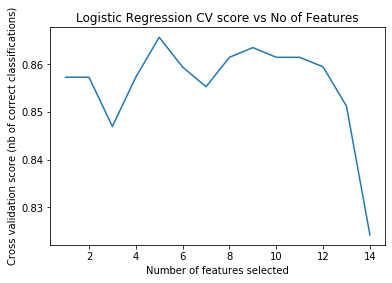

In [160]:
# plot grid_scores_
plt.figure()
plt.title('Logistic Regression CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [161]:
feature_importance = list(zip(X.columns, rfecv.support_))
rfecv_features = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        rfecv_features.append(value[0])        
print(rfecv_features)

['A4', 'A8', 'A9', 'A11', 'A12']


In [162]:
rfecv_features[0:10]

['A4', 'A8', 'A9', 'A11', 'A12']

### 6.5. Recursive feature elimination (RFE) with random forest

In [164]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=10, verbose=5)
rfe_selector.fit(X_train, y_train)

Fitting estimator with 14 features.


RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=10, step=10, verbose=5)

In [165]:
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

10 selected features


In [166]:
rfe_feature

['A2', 'A3', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A13', 'A14']

# 7. Embedded methods: Model-based selection techniques

In [91]:
# linear models benefit from feature scaling

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

### 7.1. Select features by the regression coefficients

In [104]:
# select features using the coefficient of a non
# regularised logistic regression

# here I will do the model fitting and feature selection
# altogether in one line of code

# first I specify the Logistic Regression model, here I
# select the Ridge Penalty (l2)(it is the default parameter in sklearn)

# remember that here I want to evaluate the coefficient magnitud
# itself and not whether lasso shrinks coefficients to zero

# ideally, I want to avoid regularisation at all, so the coefficients
# are not affected (modified) by the penalty of the regularisation

# In order to do this in sklearn, I set the parameter C really by
# this is basically like fitting a non regularised logistic regression

# Then I use the selectFromModel object from sklearn
# to automatically select the features
from sklearn.feature_selection import SelectFromModel

sel_ = SelectFromModel(LogisticRegression(C=1000))
sel_.fit(scaled_X_train, y_train)

# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
X_train_coef = pd.DataFrame(sel_.transform(X_train))
X_test_coef = pd.DataFrame(sel_.transform(X_test))

# add the columns name
X_train_coef.columns = X_train.columns[(sel_.get_support())]
X_test_coef.columns = X_train.columns[(sel_.get_support())]

regression_support =  X_train.columns[(sel_.get_support())]

In [106]:
# this command let's me visualise those features that were kept.

# sklearn will select those features which coefficients are greater
# than the mean of all the coefficients.

# it compares absolute values of coefficients. More on this in a second.

sel_.get_support()

array([False, False, False, False,  True, False, False,  True, False,
        True, False, False, False,  True])

In [107]:
# the number of features which coefficient was shrank to zero
# is zero, as expected, because we are not making a regularised 
# regression (I set C too big, which is inversely proportional
# to the penaly).

np.sum(sel_.estimator_.coef_ == 0)

0

In [108]:
# as select from model selects coefficients above the mean
# of all coefficients, let's calculate first the mean

sel_.estimator_.coef_.mean()

0.34738562810885226

In [105]:
print(regression_support)

Index(['A5', 'A8', 'A10', 'A14'], dtype='object')


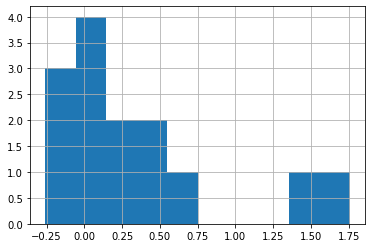

In [109]:
# and now let's plot the distribution of coefficients

pd.Series(sel_.estimator_.coef_.ravel()).hist()

As expected, some coefficients are positive and some are negative, suggesting that some features are negatively associated with the outcome (the more of the feature the less of the outcome) and viceversa.

However, the absolute value of the coefficients inform about the importance of the feature on the outcome, and not the sign. Therefore, the feature selection is done filtering on absolute values of coefficients. See below.

In [110]:
# the feature importance is informed by the absolute value of
# the coefficient, and not the sign.
# therefore, let's recalculate the mean using the absolute values instead

np.abs(sel_.estimator_.coef_).mean()

0.41401816768522537

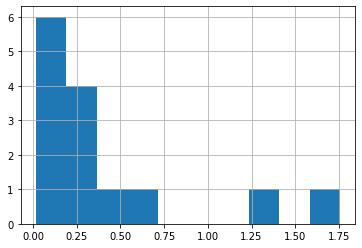

In [111]:
# and now let's plot the histogram of absolute coefficients

pd.Series(np.abs(sel_.estimator_.coef_).ravel()).hist()

In [113]:
# and now, let's compare the  amount of selected features
# with the amount of features which coefficient is above the
# mean coefficient, to make sure we understand the output of
# sklearn

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(regression_support)))
print('features with coefficients greater than the mean coefficient: {}'.format(
    np.sum(np.abs(sel_.estimator_.coef_) > np.abs(sel_.estimator_.coef_).mean())))

total features: 14
selected features: 4
features with coefficients greater than the mean coefficient: 4


Therefore, we see how select from model works. It will select all the coefficients which absolute values are greater than the mean. You can of course select a different threshold. Visit the documentation in sklearn to learn how to change this parameter.

### 7.2. Lasso Regularization

Regularization consists in adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model and in other words to avoid overfitting. In linear model regularization, the penalty is applied over the coefficients that multiply each of the predictors. From the different types of regularization, Lasso or L1 has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model

In [95]:
# First, specify the Logistic Regression model and selection the Lasso (L1) penalty
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear'))

# Second, use the selectFromModel object from sklearn, which will select
# in theory the features which coefficients are non-zero
sel_.fit(scaled_X_train, y_train)

SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                             fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l1',
                                             random_state=None,
                                             solver='liblinear', tol=0.0001,
                                             verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [96]:
# visualize those features that were kept
sel_.get_support()

array([ True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [97]:
# Make a list with the selected features

lasso_features = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(lasso_features)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 14
selected features: 12
features with coefficients shrank to zero: 2


In [98]:
# we can identify the removed features like this:
removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

Index(['A2', 'A3'], dtype='object')

In [99]:
lasso_features

Index(['A1', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14'], dtype='object')

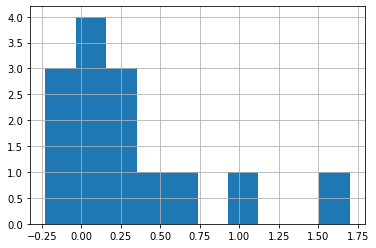

In [100]:
# plot the distribution of coefficients
pd.Series(sel_.estimator_.coef_.ravel()).hist()

As expected, some coefficients are positive and some are negative, suggesting that some features are negatively associated with the outcome (the more of the feature the less of the outcome) and viceversa.

However, the absolute value of the coefficients inform about the importance of the feature on the outcome, and not the sign. Therefore, the feature selection is done filtering on absolute values of coefficients. See below.

In [101]:
# the feature importance is informed by the absolute value of
# the coefficient, and not the sign.
# therefore, let's recalculate the mean using the absolute values instead

np.abs(sel_.estimator_.coef_).mean()

0.36547451709361006

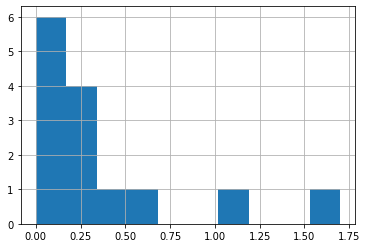

In [102]:
# and now let's plot the histogram of absolute coefficients

pd.Series(np.abs(sel_.estimator_.coef_).ravel()).hist()

In [103]:
# and now, let's compare the  amount of selected features
# with the amount of features which coefficient is above the
# mean coefficient, to make sure we understand the output of
# sklearn

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(lasso_features)))
print('features with coefficients greater than the mean coefficient: {}'.format(
    np.sum(np.abs(sel_.estimator_.coef_) > np.abs(sel_.estimator_.coef_).mean())))

total features: 14
selected features: 12
features with coefficients greater than the mean coefficient: 4


### 7.3. Regression coefficients are affected by regularisation

As I mentioned previously, regularisation applies a penalty on the coefficients, in order to reduce their influence and create models that generalise better. This is very good to improve  model performance. However, it masks the true relationship between the predictor X and the outcome Y. Let's explore why.

http://localhost:8888/notebooks/01-ML/02-General/FeatureSelection/08.3_Regression_coefficients_and_regularisation.ipynb

In [114]:
# I build 4 different models, from a highly regularised one
# to a non regularised one (C=1000)
coefs_df = []
for c in [1, 10, 100, 1000]:
    logit = LogisticRegression(C=c, penalty='l2')
    logit.fit(scaler.transform(X_train.fillna(0)), y_train)
    
    # store the coefficients of the variables in a list
    coefs_df.append(pd.Series(logit.coef_.ravel()))

In [115]:
# now I create a dataframe with the coefficients for all
# the variables for the 4 different logistic regression models

coefs = pd.concat(coefs_df, axis=1)
coefs.columns = [1, 10, 100, 1000]
coefs.index = X_train.columns
coefs.head()

,1,10,100,1000
A1,-0.074623,-0.080305,-0.081116,-0.081203
A2,-0.004121,-0.014420,-0.015727,-0.015863
A3,-0.024406,-0.039073,-0.041142,-0.041359
A4,0.118149,0.123714,0.124406,0.124475
A5,0.623057,0.643411,0.645779,0.646021


In [116]:
coefs.columns = np.log([1, 10, 100, 1000])
coefs.head()

,0.000000,2.302585,4.605170,6.907755
A1,-0.074623,-0.080305,-0.081116,-0.081203
A2,-0.004121,-0.014420,-0.015727,-0.015863
A3,-0.024406,-0.039073,-0.041142,-0.041359
A4,0.118149,0.123714,0.124406,0.124475
A5,0.623057,0.643411,0.645779,0.646021


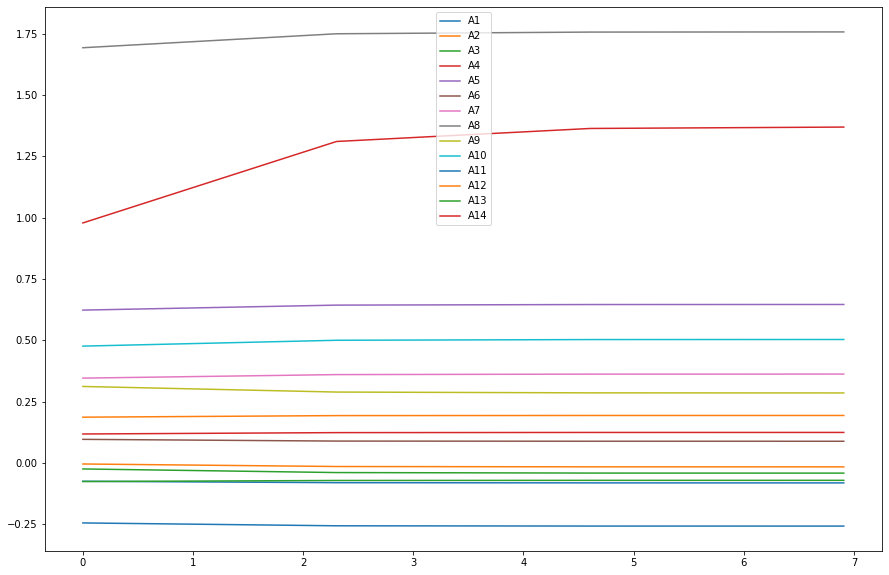

In [117]:
# plot the change in coefficients with the penalty
coefs.T.plot(figsize=(15,10))

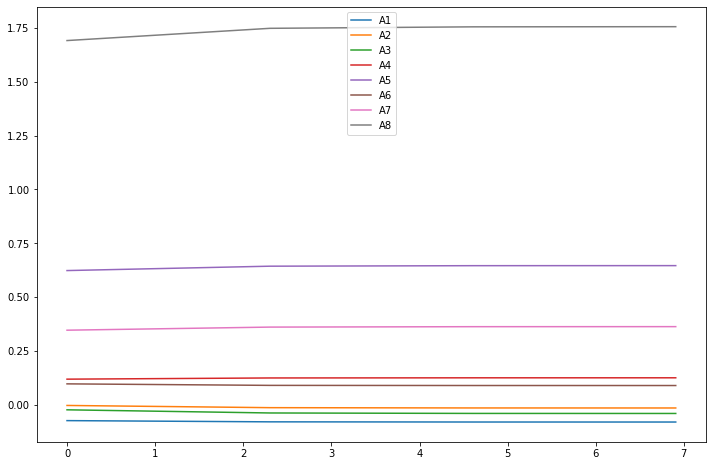

In [118]:
# now I will plot only the first 10 features for better
# visualisation

temp = coefs.head(8)
temp = temp.T
temp.plot(figsize=(12,8))

We can see that the relation among the coefficients is complex. Some features show bigger coefficients than others without regularisation, but when the penalty increases this relationship changes

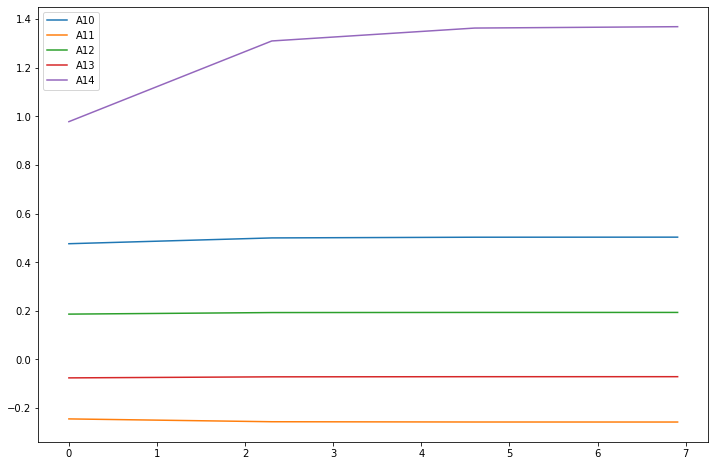

In [120]:
# plot another 10 features for visualisation
temp = coefs.tail(5)
temp = temp.T
temp.plot(figsize=(12,8))

Same as before, the relationship between features, as inferred from the coefficients, changes depending on the level of regularisation.

### 7.4. L2 Regularization

In [121]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), '1.15*median')
embeded_lr_selector.fit(X_train, y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train.loc[:,embeded_lr_support].columns.tolist()
embeded_lr_feature

['A4', 'A5', 'A7', 'A8', 'A12']

### 7.5. Select features by random forests derived importance 

Random forests are one the most popular machine learning algorithms. They are so successful because they provide in general a good predictive performance, low overfitting and easy interpretability. This interpretability is given by the fact that it is straightforward to derive the importance of each variable on the tree decision. In other words, it is easy to compute how much each variable is contributing to the decision.

Random forests consist of 4-12 hundred decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Not every tree sees all the features or all the observations, and this guarantees that the trees are de-correlated and therefore less prone to over-fitting. Each tree is also a sequence of yes-no questions based on a single or combination of features. At each node (this is at each question), the three divides the dataset into 2 buckets, each of them hosting observations that are more similar among themselves and different from the ones in the other bucket. Therefore, the importance of each feature is derived by how "pure" each of the buckets is. 

For classification, the measure of impurity is either the Gini impurity or the information gain/entropy. For regression the  measure of impurity is variance. Therefore, when training a tree, it is possible to compute how much each feature decreases the impurity. The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease from each feature can be averaged across trees to determine the final importance of the variable.

To give you a better intuition, features that are selected at the top of the trees are in general more important than features that are selected at the end nodes of the trees, as generally the top splits lead to bigger information gains.

**Note**
- Random Forests and decision trees in general give preference to features with high cardinality
- Correlated features will be given equal or similar importance, but overall reduced importance compared to the same tree built without correlated counterparts.

http://localhost:8888/notebooks/01-ML/02-General/FeatureSelection/09.2_Random_forest_importance.ipynb

In [122]:
# select features using the impotance derived from
# random forests

sel_ = SelectFromModel(RandomForestClassifier(n_estimators=400))
sel_.fit(scaled_X_train, y_train)

# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
X_train_rf = pd.DataFrame(sel_.transform(X_train))
X_test_rf = pd.DataFrame(sel_.transform(X_test))

# add the columns name
X_train_rf.columns = X_train.columns[(sel_.get_support())]
X_test_rf.columns = X_train.columns[(sel_.get_support())]

In [123]:
X_train_rf.shape, X_test_rf.shape

((483, 7), (207, 7))

In [124]:
# this command let's me visualise those features that were selected.

# sklearn will select those features which importance values
# are greater than the mean of all the coefficients.

sel_.get_support()

array([False,  True,  True, False,  True, False,  True,  True, False,
        True, False, False, False,  True])

In [125]:
# let's make a list and count the selected features
randomforest_feature = X_train.columns[(sel_.get_support())]
len(randomforest_feature)

7

In [126]:
randomforest_feature

Index(['A2', 'A3', 'A5', 'A7', 'A8', 'A10', 'A14'], dtype='object')

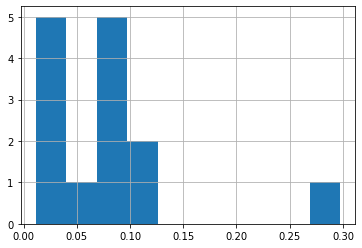

In [127]:
# and now let's plot the distribution of importances

pd.Series(sel_.estimator_.feature_importances_.ravel()).hist()

In [129]:
# and now, let's compare the  amount of selected features
# with the amount of features which importance is above the
# mean importance, to make sure we understand the output of
# sklearn

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(randomforest_feature)))
print('features with coefficients greater than the mean coefficient: {}'.format(
    np.sum(sel_.estimator_.feature_importances_ > sel_.estimator_.feature_importances_.mean())))

total features: 14
selected features: 7
features with coefficients greater than the mean coefficient: 7


Selecting features by using tree derived feature importance is a very srtaightforward, fast and generally accurate way of selecting good features for machine learning. In particular, if you are going to build tree methods.

However, as I said, correlated features will show in a tree similar and lowered importance, compared to what their importance would be if the tree was built without correlated counterparts.

In situations like this, it is better to select features recursively, rather than altogether like I am doing in this lecture.


That is all for this lecture, I hope you enjoyed it and see you in the next one!

Where we put the cut-off to select features is a bit arbitrary. One way is to select the top 10, 20 features. Alternatively, the top 10th percentile. For this, you can use mutual info in combination with SelectKBest or SelectPercentile from sklearn. See below.

In [130]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.15*median')
embeded_rf_selector.fit(X_train, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
embeded_rf_feature

['A7', 'A8', 'A10']

### 7.6. Recursive feature selection using random forests importance

Random Forests assign equal or similar importance to features that are highly correlated. In addition, when features are correlated, the importance assigned is lower than the importance attributed to the feature itself, should the tree be built without the correlated counterparts.

Therefore, instead of eliminating features based  on importance by brute force like we did in the previous lecture, we may get a better selection by removing one feature at a time, and recalculating the importance on each round.

This method is an hybrid between embedded and wrapper methods: it is based on computation derived when fitting the model, but it also requires fitting several models.

The cycle is as follows:

- Build random forests using all features
- Remove least important feature
- Build random forests and recalculate importance
- Repeat until a criteria is met

In this situation, when a feature that is highly correlated to another one is removed, then, the importance of the remaining feature increases. This may lead to a better subset feature space selection. On the downside, building several random forests is quite time consuming, in particular if the dataset contains a high number of features.

In [133]:
# first I specify the Random Forest instance, indicating the number of trees

# Then I use the selectFromModel object from sklearn to automatically select the features

# RFE will remove one feature at each iteration, the least  important.
# then it will build another random forest and repeat till a criteria is met.

# in sklearn the criteria to stop is an arbitrary number of features to select, that you need to decide before hand
# not the best solution, but a solution

sel_ = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=10)
sel_.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=10, step=1, verbose=0)

In [134]:
# this command let's me visualise those features that were selected.
sel_.get_support()

array([False,  True,  True, False,  True,  True,  True,  True,  True,
        True, False, False,  True,  True])

In [135]:
# let's add the variable names and order it for clearer visualisation
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

10

In [136]:
# let's display the list of features
selected_feat

Index(['A2', 'A3', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A13', 'A14'], dtype='object')

### 7.7. LightGBM

In [137]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.15*median')
embeded_lgb_selector.fit(X_train, y_train)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X_train.loc[:,embeded_lgb_support].columns.tolist()
embeded_lgb_feature

['A2', 'A3', 'A7', 'A9', 'A11', 'A14']

### 7.8. Gradient Boosted trees importance

Similarly to selecting features using Random Forests derived feature importance, you can select features based on the importance derived by gradient boosted trees. And you can do that in one go, or in a recursive manner, depending on how much time you have, how many features are in the dataset, and whether they are correlated or not.

I will demonstrate how to select features using Gradient boosted trees derived importance using sklearn on a classification problem, using the Paribas claims dataset from Kaggle.

In [139]:
# first I will select features all together in one go
# by contemplating their importance after fitting only
# 1 gradient boosted tree

sel_ = SelectFromModel(GradientBoostingClassifier())
sel_.fit(X_train, y_train)

SelectFromModel(estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                     criterion='friedman_mse',
                                                     init=None,
                                                     learning_rate=0.1,
                                                     loss='deviance',
                                                     max_depth=3,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                               

In [140]:
# let's add the variable names and order it for clearer visualisation
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

1

In [141]:
selected_feat

Index(['A8'], dtype='object')

In [143]:
# next I will select features recursively for comparison

sel_ = RFE(GradientBoostingClassifier(), n_features_to_select=len(selected_feat))
sel_.fit(X_train, y_train)

RFE(estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                         criterion='friedman_mse', init=None,
                                         learning_rate=0.1, loss='deviance',
                                         max_depth=3, max_features=None,
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=100,
                                         n_iter_no_change=None,
                                         presort='deprecated',
                                         random_state=None, subsample=1.0,
                                         tol=0.0001, validation_f

In [144]:
# let's add the variable names and order it for clearer visualisation
selected_feat_rfe = X_train.columns[(sel_.get_support())]
len(selected_feat_rfe)

1

In [145]:
selected_feat_rfe

Index(['A8'], dtype='object')

In [146]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier

embeded_gbt_selector = SelectFromModel(GradientBoostingClassifier())
embeded_gbt_selector.fit(X_train, y_train)

embeded_gbt_support = embeded_gbt_selector.get_support()
embeded_gbt_feature = X_train.loc[:,embeded_gbt_support].columns.tolist()
embeded_gbt_feature

['A8']

### 7.9. Feature selection by random shuffling

A popular method of feature selection consists in random shuffling the values of a specific variable and determining how that permutation affects the performance metric of the machine learning algorithm. In other words, the idea is to permute the values of each feature, one at the time, and measure how much the permutation decreases the accuracy, or the roc_auc, or the mse of the machine learning model. If the variables are important, this is, highly predictive, a random permutation of their values will decrease dramatically any of these metrics. Contrarily, non-important / non-predictive variables, should have little to no effect on the model performance metric we are assessing.

I will demonstrate how to select features based on random shuffling using on a regression and classification problem. For classification I will use the Paribas claims dataset from Kaggle. For regression, the House Price dataset from Kaggle.

**Note** For the demonstration, I will continue to use Random Forests, but this method is useful for any machine learning algorithm. In fact, the importance of the features are determined specifically for the algorithm used. Therefore, different algorithms may return different subsets of important features.

In [147]:
# The first step to determine feature importance by feature shuffling
# is to build the machine learning model for which we want to 
# select features

# In this case, I will build Random Forests, but remember that 
# you can use this procedure for any other machine learning algorithm

# I build few and shallow trees to avoid overfitting
rf = RandomForestClassifier(
    n_estimators=50, max_depth=2, random_state=2909, n_jobs=4)

rf.fit(X_train, y_train)

# print roc-auc in train and testing sets
print('train auc score: ',
      roc_auc_score(y_train, (rf.predict_proba(X_train.fillna(0)))[:, 1]))
print('test auc score: ',
      roc_auc_score(y_test, (rf.predict_proba(X_test.fillna(0)))[:, 1]))

train auc score:  0.9415133634154808
test auc score:  0.9175803402646502


In [148]:
# in this cell, I will shuffle one by one, each feature of the dataset
# and then use the dataset with the shuffled variable to make predictions
# using the random forests I trained in the previous cell

# overall train roc-auc: using all the features
train_auc = roc_auc_score(y_train, (rf.predict_proba(X_train.fillna(0)))[:, 1])

# dictionary to capture the features and the drop in auc that they
# cause when shuffled
feature_dict = {}

# selection  logic
for feature in X_train.columns:
    X_train_c = X_train.copy()
    
    # shuffle individual feature
    X_train_c[feature] = X_train_c[feature].sample(frac=1).reset_index(
        drop=True)
    
    # make prediction with shuffled feature and calculate roc-auc
    shuff_auc = roc_auc_score(y_train,
                              (rf.predict_proba(X_train_c.fillna(0)))[:, 1])
    
    # save the drop in roc-auc
    feature_dict[feature] = (train_auc - shuff_auc)

In [149]:
# let's have a look at the generated dictionary
feature_dict

{'A1': 0.0,
 'A2': 0.0009979173897952665,
 'A3': 0.003644567858382519,
 'A4': -0.0006768483165566774,
 'A5': 0.001735508503991734,
 'A6': 0.0014925373134327957,
 'A7': 0.0032540784449844873,
 'A8': 0.17703922249219028,
 'A9': 0.007427976397084368,
 'A10': -0.0009718847622353088,
 'A11': 0.0,
 'A12': 0.0023950017355085507,
 'A13': 0.0007636237417564251,
 'A14': 0.0033582089552239847}

In [150]:
# Now I will transform the dictionary into a pandas dataframe
# for easy manipulation

feature_importance = pd.Series(feature_dict).reset_index()
feature_importance.columns = ['feature', 'auc_drop']
feature_importance.head()

,feature,auc_drop
0,A1,0.000000
1,A2,0.000998
2,A3,0.003645
3,A4,-0.000677
4,A5,0.001736


In [152]:
# Now I will sort the dataframe according to the drop in performance
# caused by feature shuffling

feature_importance.sort_values(by=['auc_drop'], ascending=False, inplace=True)

# visualise the top 10 features that caused the major drop
# in roc-auc (aka model performance)

feature_importance.head(10)

,feature,auc_drop
7,A8,0.177039
8,A9,0.007428
2,A3,0.003645
13,A14,0.003358
6,A7,0.003254
11,A12,0.002395
4,A5,0.001736
5,A6,0.001493
1,A2,0.000998
12,A13,0.000764


In [153]:
# visualise the features that caused virtually 
# no drop in performance

feature_importance.tail(10)

,feature,auc_drop
6,A7,0.003254
11,A12,0.002395
4,A5,0.001736
5,A6,0.001493
1,A2,0.000998
12,A13,0.000764
0,A1,0.000000
10,A11,0.000000
3,A4,-0.000677
9,A10,-0.000972


In [154]:
# original number of features (rows in this case)
feature_importance.shape[0]

14

In [155]:
# number of features that cause a drop in performance
# when shuffled

feature_importance[feature_importance.auc_drop>0].shape[0]

10

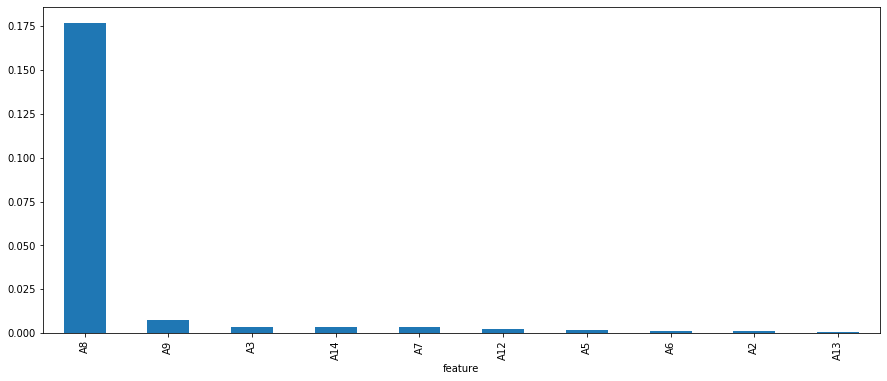

In [156]:
# and now let's plot the distribution of importances
# for those features that are actually important

# capture the important features in a series for visualisation
temp = pd.Series(feature_importance[feature_importance.auc_drop>0]['auc_drop'])
temp.index = pd.Series(feature_importance[feature_importance.auc_drop>0]['feature'])

pd.Series(temp).plot.bar(figsize=(15,6))

In [157]:
# Now let's build a random forests only with the 26 selected features

# capture the 26 selected features
selected_features = feature_importance[feature_importance.auc_drop>0]['feature']

# train a new random forests using only the selected features
rf = RandomForestClassifier(
    n_estimators=50, max_depth=2, random_state=2909, n_jobs=4)

rf.fit(X_train[selected_features].fillna(0), y_train)

# print roc-auc in train and testing sets
print('train auc score: ',
      roc_auc_score(y_train, (rf.predict_proba(X_train[selected_features].fillna(0)))[:, 1]))
print('test auc score: ',
      roc_auc_score(y_test, (rf.predict_proba(X_test[selected_features].fillna(0)))[:, 1]))

train auc score:  0.9444810829573066
test auc score:  0.9160680529300568


### 7.10. Tree based feature selection

Feature ranking:
1. feature 7 (0.277549)
2. feature 6 (0.107070)
3. feature 9 (0.087541)
4. feature 2 (0.082095)
5. feature 4 (0.078023)
6. feature 13 (0.075933)
7. feature 12 (0.074457)
8. feature 8 (0.071504)
9. feature 1 (0.070717)
10. feature 5 (0.027043)
11. feature 10 (0.012707)
12. feature 3 (0.012155)
13. feature 11 (0.011966)
14. feature 0 (0.011239)


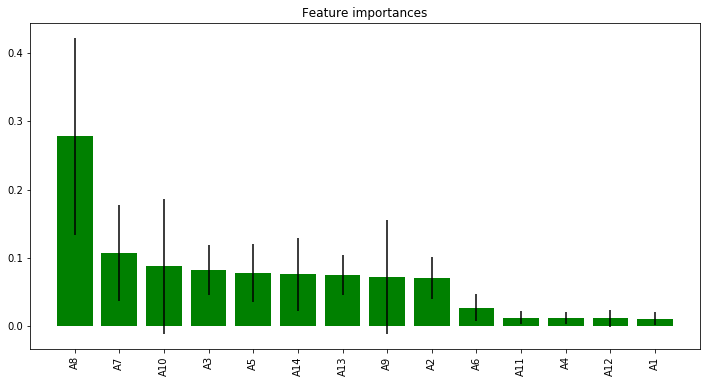

In [158]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clr_rf_5.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# 8. Hybrid methods

### Hybrid Recursive Feature Elimination

http://localhost:8888/notebooks/01-ML/02-General/FeatureSelection/11.02_Hybrid_Recursive_feature_elimination.ipynb

This method consists of the following steps:

1) Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance, or LASSO / Ridge, or the linear / logistic regression coefficients.

2) Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.

3) Calculate a performance metric of your choice: roc-auc, mse, rmse, accuracy.

4) If the metric decreases by more of an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

5) Repeat steps 2-4 until all features have been removed (and therefore evaluated) and the drop in performance assessed.


I call this a hybrid method because:

- it combines the importance derived from the machine learning algorithm like embedded methods,
- and it removes as well one feature at a time, and calculates a new metric based on the new subset of features and the machine learning algorithm of choice, like wrapper methods.

The difference between this method and the step backwards feature selection we learned in previous lectures lies in that it does not remove all features first in order to determine which one to remove. It removes the least important one, based on the machine learning model derived important. And then, it makes an assessment as to whether that feature should be removed or not. So it removes each feature only once during selection, whereas step backward feature selection removes all the features at each step of selection.

This method is therefore faster than wrapper methods and generally better than embedded methods. In practice it works extremely well. It does also account for correlations (depending on how stringent you set the arbitrary performance drop threshold). On the downside, the drop in performance assessed to decide whether the feature should be kept or removed, is set arbitrarily. The smaller the drop the more features will be selected, and vice versa.

I will demonstrate how to select features using this method on a regression and classification problem. For classification I will use the Paribas claims dataset from Kaggle. For regression, the House Price dataset from Kaggle.

**Note** For the demonstration, I will use XGBoost, but this method is useful for any machine learning algorithm. In fact, the importance of the features are determined specifically for the algorithm used. Therefore, different algorithms may return different subsets of important features

In [182]:
# the first step of this procedure  consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict_proba(X_test)[:, 1]
auc_score_all = roc_auc_score(y_test, y_pred_test)
print('Test all features xgb ROC AUC=%f' % (auc_score_all))

Test all features xgb ROC AUC=0.925824


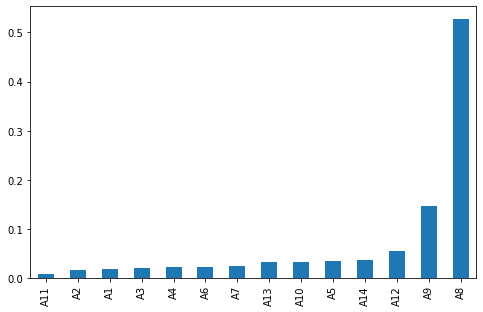

In [183]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the least to the most
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(8,5))

In [184]:
# view the list of ordered features
features = list(features.index)
print(features)

['A11', 'A2', 'A1', 'A3', 'A4', 'A6', 'A7', 'A13', 'A10', 'A5', 'A14', 'A12', 'A9', 'A8']


In [185]:
# the final step consists in removing one at a time
# all the features, from the least to the most
# important, and build an xgboost at each round.

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is smaller than the original one
# (with all the features), then that feature that was removed
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature elimination:

# first we arbitrarily set the drop in roc-auc
# if the drop is below this threshold,
# the feature will be removed
tol = 0.0005

print('doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = xgb.XGBClassifier(
        nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

    # fit model with all variables minus the removed features
    # and the feature to be evaluated
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test.drop(features_to_remove + [feature], axis=1))[:, 1]

    # calculate the new roc-auc
    auc_score_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((auc_score_int)))

    # print the original roc-auc with all the features
    print('All features Test ROC AUC={}'.format((auc_score_all)))

    # determine the drop in the roc-auc
    diff_auc = auc_score_all - auc_score_int

    # compare the drop in roc-auc with the tolerance
    # we set previously
    if diff_auc >= tol:
        print('Drop in ROC AUC={}'.format(diff_auc))
        print('keep: ', feature)
        print
    else:
        print('Drop in ROC AUC={}'.format(diff_auc))
        print('remove: ', feature)
        print
        # if the drop in the roc is small and we remove the
        # feature, we need to set the new roc to the one based on
        # the remaining features
        auc_score_all = auc_score_int
        
        # and append the feature to remove to the collecting
        # list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

doing recursive feature elimination

testing feature:  A11  which is feature  1  out of  14
New Test ROC AUC=0.9279184917158636
All features Test ROC AUC=0.9258236526375928
Drop in ROC AUC=-0.0020948390782707937
remove:  A11

testing feature:  A2  which is feature  2  out of  14
New Test ROC AUC=0.930917920396115
All features Test ROC AUC=0.9279184917158636
Drop in ROC AUC=-0.0029994286802513814
remove:  A2

testing feature:  A1  which is feature  3  out of  14
New Test ROC AUC=0.9314416301656827
All features Test ROC AUC=0.930917920396115
Drop in ROC AUC=-0.0005237097695677262
remove:  A1

testing feature:  A3  which is feature  4  out of  14
New Test ROC AUC=0.9220148543134641
All features Test ROC AUC=0.9314416301656827
Drop in ROC AUC=0.009426775852218627
keep:  A3

testing feature:  A4  which is feature  5  out of  14
New Test ROC AUC=0.9247762330984575
All features Test ROC AUC=0.9314416301656827
Drop in ROC AUC=0.006665397067225243
keep:  A4

testing feature:  A6  which is featu

In [186]:
# capture the 56 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_xgb = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# fit the model with the selected features
final_xgb.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = final_xgb.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
auc_score_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (auc_score_final))
print('Test all features ROC AUC=%f' % (auc_score_all))

Test selected features ROC AUC=0.933156
Test all features ROC AUC=0.933156


As you can see, the xgb model built with 56 features shows a similar performance than the one built with the total features (0.715 vs 0.713).

We may not be able to get this right from the beginning though, as we did here. This method of feature selection does require that you try a few different tolerances / thresholds until you find the right number of features.

Why don't you go ahead and try different values? Try with lower and bigger thresholds and get a feeling of how much this affects the number of selected features.

### Hybrid Recursive Feature Addition

http://localhost:8888/notebooks/01-ML/02-General/FeatureSelection/11.03_Hybrid_Recursive_feature_addition.ipynb

This method consists of the following steps:

1) Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance, or LASSO / Ridge, or the linear / logistic regression coefficients.

2) Build a machine learning model with only 1 feature, the most important one, and calculate the model metric for performance.

3) Add one feature -the most important- and build a machine learning algorithm utilising the added and any feature from previous rounds.

4) Calculate a performance metric of your choice: roc-auc, mse, rmse, accuracy.

5) If the metric increases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

6) Repeat steps 2-5 until all features have been removed (and therefore evaluated) and the drop in performance assessed.


I call this a hybrid method because:

- it combines the importance derived from the machine learning algorithm like embedded methods,
- and it adds as well one feature at a time, and calculates a new metric based on the new subset of features and the machine learning algorithm of choice, like wrapper methods.

The difference between this method and the step forward feature selection we learned in previous lectures lies in that it does not add all possible features first, in order to determine which one to keep. It adds the most important one, based on the machine learning model derived important. And then, it makes an assessment as to whether that feature should be kept or not. And then it moves to the next feature.

This method is therefore faster than wrapper methods and generally better than embedded methods. In practice it works extremely well. It does also account for correlations (depending on how stringent you set the arbitrary performance drop threshold). On the downside, the increase in performance assessed to decide whether the feature should be kept or removed, is set arbitrarily. The smaller the increase the more features will be selected, and vice versa.

I will demonstrate how to select features using this method on a regression and classification problem. For classification I will use the Paribas claims dataset from Kaggle. For regression, the House Price dataset from Kaggle.

**Note** For the demonstration, I will use XGBoost, but this method is useful for any machine learning algorithm. In fact, the importance of the features are determined specifically for the algorithm used. Therefore, different algorithms may return different subsets of important features.

In [187]:
# the first step of this procedure  consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict_proba(X_test)[:, 1]
auc_score_all = roc_auc_score(y_test, y_pred_test)
print('Test all features xgb ROC AUC=%f' % (auc_score_all))

Test all features xgb ROC AUC=0.925824


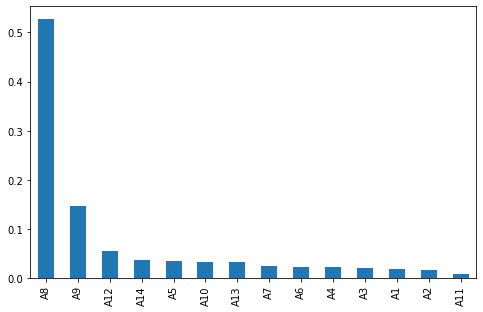

In [188]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the most to the least
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(8,5))

In [189]:
# view the list of ordered features
features = list(features.index)
print(features)

['A8', 'A9', 'A12', 'A14', 'A5', 'A10', 'A13', 'A7', 'A6', 'A4', 'A3', 'A1', 'A2', 'A11']


In [190]:
# next, we need to build a machine learning
# algorithm using only the most important feature

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_one_feature = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# train using only the most important feature
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]
auc_score_first = roc_auc_score(y_test, y_pred_test)
print('Test one feature xgb ROC AUC=%f' % (auc_score_first))

Test one feature xgb ROC AUC=0.870310


In [191]:
# the final step consists in adding one at a time
# all the features, from the most to the least
# important, and build an xgboost at each round.

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is bigger than the original one
# (with one feature), then that feature that was added
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature addition:

# first we arbitrarily set the increase in roc-auc
# if the increase is above this threshold,
# the feature will be kept
tol = 0.001

print('doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = xgb.XGBClassifier(
        nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test[features_to_keep + [feature] ])[:, 1]

    # calculate the new roc-auc
    auc_score_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((auc_score_int)))

    # print the original roc-auc with one feature
    print('All features Test ROC AUC={}'.format((auc_score_first)))

    # determine the increase in the roc-auc
    diff_auc = auc_score_int - auc_score_first

    # compare the increase in roc-auc with the tolerance
    # we set previously
    if diff_auc >= tol:
        print('Increase in ROC AUC={}'.format(diff_auc))
        print('keep: ', feature)
        print
        # if the increase in the roc is bigger than the threshold
        # we keep the feature and re-adjust the roc-auc to the new value
        # considering the added feature
        auc_score_first = auc_score_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in ROC AUC={}'.format(diff_auc))
        print('remove: ', feature)
        print


# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  A9  which is feature  1  out of  14
New Test ROC AUC=0.8955437059607694
All features Test ROC AUC=0.8703104170634165
Increase in ROC AUC=0.02523328889735288
keep:  A9

testing feature:  A12  which is feature  2  out of  14
New Test ROC AUC=0.9086840601790135
All features Test ROC AUC=0.8955437059607694
Increase in ROC AUC=0.01314035421824411
keep:  A12

testing feature:  A14  which is feature  3  out of  14
New Test ROC AUC=0.9077794705770329
All features Test ROC AUC=0.9086840601790135
Increase in ROC AUC=-0.0009045896019805877
remove:  A14

testing feature:  A5  which is feature  4  out of  14
New Test ROC AUC=0.9078270805560845
All features Test ROC AUC=0.9086840601790135
Increase in ROC AUC=-0.0008569796229289661
remove:  A5

testing feature:  A10  which is feature  5  out of  14
New Test ROC AUC=0.9146829175395164
All features Test ROC AUC=0.9086840601790135
Increase in ROC AUC=0.005998857360502874
keep:  A10

testing feature:  A

In [192]:
# capture the 8 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_xgb = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# fit the model with the selected features
final_xgb.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = final_xgb.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
auc_score_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (auc_score_final))

Test selected features ROC AUC=0.922348


# 10. Summary

In [167]:
len(feature_name)

14

In [168]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name,
                                     'Pearson':cor_support,
                                    'ROC-AUC':rocauc_support,
                                   # 'Chi-2':chi_support, 
                                    'RFE':rfe_support, 
                                    'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support,
                           #         'LightGBM':embeded_lgb_support,
                                    'Gradient Boosting Trees':embeded_gbt_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(30)

,Feature,Pearson,ROC-AUC,RFE,Logistics,Random Forest,Gradient Boosting Trees,Total
1,A8,True,True,True,True,True,True,6
2,A7,True,False,True,True,True,False,4
3,A5,True,True,True,True,False,False,4
4,A10,True,True,True,False,True,False,4
5,A9,True,True,True,False,False,False,3
6,A14,False,True,True,False,False,False,2
7,A13,False,True,True,False,False,False,2
8,A6,False,False,True,False,False,False,1
9,A4,False,False,False,True,False,False,1
10,A3,False,False,True,False,False,False,1


In [169]:
np.array(feature_selection_df[feature_selection_df.Total > 1].Feature)

array(['A8', 'A7', 'A5', 'A10', 'A9', 'A14', 'A13'], dtype=object)

# Compare the performance in Random Forest

In [105]:
# create a function to build random forests and compare performance in train and test set

def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [106]:
# original
run_randomForests(X_train_original,X_test_original,y_train, y_test)

Train set
Random Forests roc-auc: 0.9677687380993596
Test set
Random Forests roc-auc: 0.9318225099980956


In [108]:
# filter methods - basic
run_randomForests(X_train_basic_filter,X_test_basic_filter,y_train, y_test)

Train set
Random Forests roc-auc: 0.9677687380993596
Test set
Random Forests roc-auc: 0.9318225099980956


In [109]:
# filter methods - correlation
run_randomForests(X_train_corr,X_test_corr,y_train, y_test)

Train set
Random Forests roc-auc: 0.9677687380993596
Test set
Random Forests roc-auc: 0.9318225099980956


In [110]:
# filter methods - univariate roc-auc
run_randomForests(X_train[selected_feat.index],X_test_corr[selected_feat.index],y_train, y_test)

Train set
Random Forests roc-auc: 0.9678899082568807
Test set
Random Forests roc-auc: 0.9292991811083603


In [111]:
# embedded methods - Logistic regression coefficients
run_randomForests(X_train_coef,
                  X_test_coef,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9487450233685303
Test set
Random Forests roc-auc: 0.9175395162826128


Selecting features using the logistic regression coefficients gives a slightly worse performance than the univariate roc-auc (0.798 vs 0.795). However, keep in mind that the univariate model is using 90 features vs the only 28 used by the coefficients selection method. This means that many of those 90 features are still redundant, and we could potentially reduce the feature space further without loosing performance significantly.

In [121]:
# embedded methods - Random forests
run_randomForests(X_train_rf,
                  X_test_rf,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.966920546996711
Test set
Random Forests roc-auc: 0.9351552085317082


Well this was a big jump!! We can see how by selecting features using random forest importance, we reduce the feature space up to only 16 features, and yet the algorithm shows a greater predictive performance compared to the one using more features (0.813 vs 0.798)!!!

We can see the power of feature selection now!

# Logistic Regression

In [112]:
# create a function to build logistic regression and compare performance in train and test set

def run_logistic(X_train, X_test, y_train, y_test):
    # function to train and test the performance of logistic regression
    logit = LogisticRegression(random_state=44)
    logit.fit(X_train, y_train)
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [114]:
# original
scaler = StandardScaler().fit(X_train_original)

run_logistic(scaler.transform(X_train_original),scaler.transform(X_test_original),y_train, y_test)

Train set
Logistic Regression roc-auc: 0.9466678206681669
Test set
Logistic Regression roc-auc: 0.910207579508665


In [115]:
# filter methods - basic
scaler = StandardScaler().fit(X_train_basic_filter)

run_logistic(scaler.transform(X_train_basic_filter),scaler.transform(X_test_basic_filter),y_train, y_test)

Train set
Logistic Regression roc-auc: 0.9466678206681669
Test set
Logistic Regression roc-auc: 0.910207579508665


In [116]:
# filter methods - correlation
scaler = StandardScaler().fit(X_train_corr)

run_logistic(scaler.transform(X_train_corr),scaler.transform(X_test_corr),y_train, y_test)

Train set
Logistic Regression roc-auc: 0.9466678206681669
Test set
Logistic Regression roc-auc: 0.910207579508665


In [117]:
# filter methods - univariate roc-auc
scaler = StandardScaler().fit(X_train[selected_feat.index])

run_logistic(scaler.transform(X_train[selected_feat.index]),
             scaler.transform(X_test_corr[selected_feat.index]),
                  y_train, y_test)

Train set
Logistic Regression roc-auc: 0.9466851306906698
Test set
Logistic Regression roc-auc: 0.9122071986288326


In [118]:
# embedded methods - Logistic regression coefficients
run_randomForests(X_train_coef,
                  X_test_coef,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9487450233685303
Test set
Random Forests roc-auc: 0.9175395162826128


In this case, we can see that the selection of features using the feature coefficient led to a better performing logistic regression model (0.795 vs 0.794) compared to univariate feature selection. In addition, the new model has 28 vs 90 features, so it is a win-win :)

That is all for this lecture. I hope you enjoyed it!

In [122]:
# embedded methods - Random Forests importance

scaler = StandardScaler().fit(X_train_rf)

run_logistic(
    scaler.transform(X_train_rf), scaler.transform(X_test_rf), y_train, y_test)

Train set
Logistic Regression roc-auc: 0.938999480699325
Test set
Logistic Regression roc-auc: 0.9197295753189868


With Logistic regression we were not so lucky. This makes sense on the other hand, because selection of features by random forest importance, optimises feature selection for tree based methods, as it is able to capture non-linearities that linear regression can not.

Therefore, if we are selecting features for a linear model, it is better to use selection procedures targeted to those models, like importance by regression coefficient or Lasso. And if we are selecting features for trees, it is better to use tree derived importance.

That is all for this lecture. I hope you enjoyed it!

# Compare performance using Gradient Boosting Tree

In [179]:
# create a function to build gradient boosted trees
# and compare performance in train and test set


def run_gradientboosting(X_train, X_test, y_train, y_test):
    rf = GradientBoostingClassifier(
        n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(
        roc_auc_score(y_train, pred[:, 1])))
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(
        roc_auc_score(y_test, pred[:, 1])))

In [180]:
# features selected recursively
run_gradientboosting(X_train[selected_feat_rfe].fillna(0),
                  X_test[selected_feat_rfe].fillna(0),
                  y_train, y_test)# features selected altogether

Train set
Random Forests roc-auc: 0.8580491604639086
Test set
Random Forests roc-auc: 0.8703104170634165


In [181]:
# features selected altogether
run_gradientboosting(X_train[selected_feat].fillna(0),
                  X_test[selected_feat].fillna(0),
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8580491604639086
Test set
Random Forests roc-auc: 0.8703104170634165
